In [1]:
import pandas as pd
data=pd.read_csv('../raw_data/Tool_Info.csv')
data['age']=2019-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95

# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 
                        'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']])
data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()

data.head()

,ID,aligner,url,year_of_pub,application,indexing,fix_length_seed,spaced_seed,seed_chaining,pairwise_alignment,...,num_citations,wrapper,wrapper_of,age,citation_per_year,index,pairwise,seeds_fixed,seeds_chained,seeds_spaced
0,104,BatMeth2,https://github.com/GuoliangLi-HZAU/BatMeth2/,2019,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,2,N,NaN,1,2.000000,BWT-FM,Multiple Methods,Yes,Yes,No
1,63,BS-Seeker2,https://github.com/BSSeeker/BSseeker2,2013,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,173,Y,Bowtie2,7,24.714286,BWT-FM,Multiple Methods,Yes,Yes,No
2,54,BRAT-BW,http://compbio.cs.ucr.edu/brat/,2012,BS-Seq,BWT-FM,N,N,N,HD,...,70,N,NaN,8,8.750000,BWT-FM,Hamming Distance,No,No,No
3,43,Bismark,https://github.com/FelixKrueger/Bismark,2011,BS-Seq,BWT-FM,Y,N,Y,SW & NW,...,1550,Y,Bowtie2 or HISAT2,9,172.222222,BWT-FM,Multiple Methods,Yes,Yes,No
4,32,BS-Seeker,https://github.com/BSSeeker/BSseeker2,2010,BS-Seq,BWT-FM,Y,N,N,HD,...,215,Y,Bowtie,10,21.500000,BWT-FM,Hamming Distance,Yes,No,No


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

In [58]:
data_year.loc[data_year['application'].str.contains('DNA'), :]

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,aligner_lower
7,2019,HISAT2,DNA,BWT-FM,Non-DP Heuristic,Yes,No,No,hisat2
8,2019,BWA-MEM2,DNA,BWT-FM,Smith-Waterman,No,No,Yes,bwa-mem2
9,2018,NGMLR,DNA,Hashing,Smith-Waterman,Yes,No,Yes,ngmlr
10,2018,lordFAST,DNA,BWT-FM & Hashing,Multiple Methods,No,No,Yes,lordfast
11,2018,MUMmer4,DNA,Other Suffix,Smith-Waterman,Yes,No,Yes,mummer4
12,2018,DREAM-Yara,DNA,BWT-FM,Other DP,Yes,No,No,dream-yara
13,2017,KART,DNA,BWT-FM,Needleman-Wunsch,No,No,Yes,kart
14,2016,NanoBLASTer,DNA,Hashing,Needleman-Wunsch,Yes,No,Yes,nanoblaster
15,2016,rHAT,DNA,Hashing,Smith-Waterman,Yes,No,Yes,rhat
16,2016,minimap,DNA,Hashing,NaN,Yes,No,No,minimap


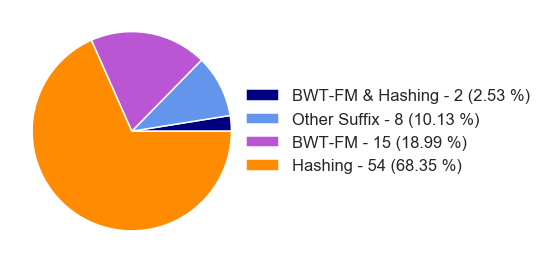

In [56]:
plt.figure(figsize=(11,4))
sns.set_style('white')
sns.set_context('talk')
idx_group = data_year.loc[data_year['application'].str.contains('DNA'), :].groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
plt.savefig('../figures/Figure2_a_0.png')
plt.savefig('../figures/Figure2_a_0.pdf')

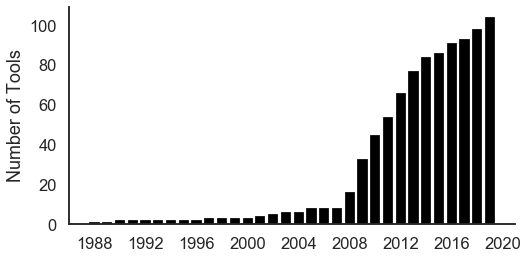

In [67]:
plt.figure(figsize=(8,4))

idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})
#year_melt

by_year.loc[:,'Total'] = by_year.sum(axis=1)
Total = by_year['Total'].to_list()
#Total
sns.set_style('white')
sns.set_context('talk')

barWidth = 1
plt.bar(x, Total, color='black', linewidth=.25)
#plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.ylabel("Number of Tools")
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_a_3.png')
plt.savefig('../figures/Figure2_a_3.pdf')

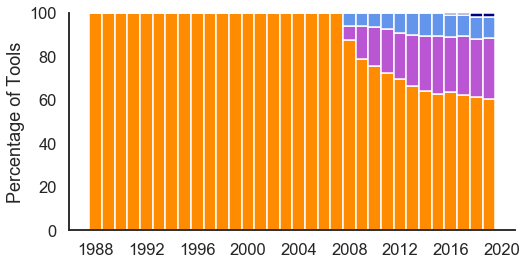

In [45]:
plt.figure(figsize=(8,4))

totals = [i+j+k+l for i,j,k,l in zip(by_year['BWT-FM'], by_year['BWT-FM & Hashing'], by_year['Hashing'], 
                                    by_year['Other Suffix'])]
BWT = [i / j * 100 if j != 0 else 0 for i,j in zip(by_year['BWT-FM'], totals)]
Both = [i / j * 100 if j != 0 else 0 for i,j in zip(by_year['BWT-FM & Hashing'], totals)]
Hash = [i / j * 100 if j != 0 else 100 for i,j in zip(by_year['Hashing'], totals)]
Other = [i / j * 100 if j != 0 else 0 for i,j in zip(by_year['Other Suffix'], totals)]


sns.set_style('white')
sns.set_context('talk')

# plot
barWidth = 1
plt.bar(x, Hash, color='darkorange', edgecolor='white', width=barWidth)
plt.bar(x, BWT, bottom=Hash, color='mediumorchid', edgecolor='white', width=barWidth)
plt.bar(x, Other, bottom=[i+j for i,j in zip(Hash, BWT)], color='cornflowerblue', 
        edgecolor='white', width=barWidth)
plt.bar(x, Both, bottom=[i+j+k for i,j,k in zip(Hash, BWT, Other)], color='navy', 
        edgecolor='white', width=barWidth)
 
# Custom x axis
# plt.xticks(x, names)
# plt.xlabel("Year")
plt.ylabel("Percentage of Tools")
 
sns.despine()
# Show graphic
# plt.show()

#plt.legend(('Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'), loc='center left', bbox_to_anchor=(1, .5))
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
# plt.show()

# plt.tight_layout()
plt.savefig('../figures/Figure2_a_1.png')
plt.savefig('../figures/Figure2_a_1.pdf')

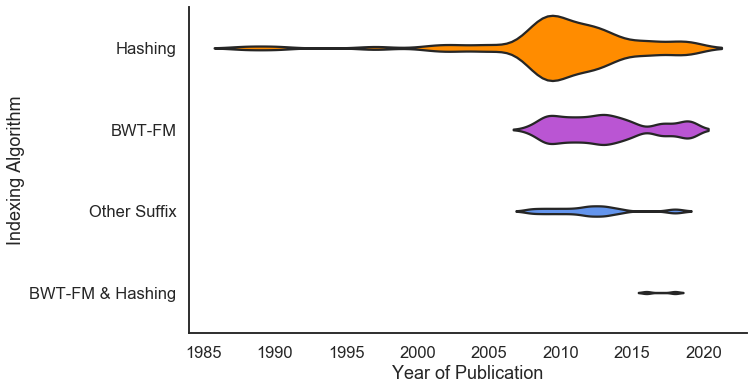

In [46]:
plt.figure(figsize=(10, 6))
sns.set_style('white')
sns.set_context('talk')

g = sns.violinplot(data=data_year, x='year_of_pub', y='index', scale='count', bw=.2, inner=None,
                   order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'], palette=index_clrs, saturation=1)

plt.ylabel("Indexing Algorithm")
plt.xlabel("Year of Publication")

sns.despine()

#plt.show()

plt.savefig('../figures/Figure2_a_4.png')
plt.savefig('../figures/Figure2_a_4.pdf')

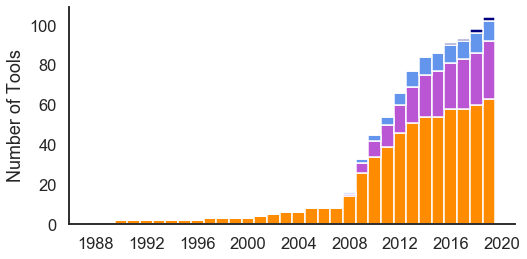

In [47]:
plt.figure(figsize=(8,4))

sns.set_style('white')
sns.set_context('talk')

#plot_df = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], value_vars=['BWT-FM', 'BWT-FM & Hashing', 
#                                                                        'Hashing', 'Other Suffix', 'Total'], 
#                  var_name='index', value_name='count')

BWT = by_year['BWT-FM'].to_list()
Both = by_year['BWT-FM & Hashing'].to_list()
Hash = by_year['Hashing'].to_list()
Other = by_year['Other Suffix'].to_list()

barWidth = 1
plt.bar(x, Hash, color='darkorange', edgecolor='white', width=barWidth)
plt.bar(x, BWT, bottom=Hash, color='mediumorchid', edgecolor='white', width=barWidth)
plt.bar(x, Other, bottom=[i+j for i,j in zip(Hash, BWT)], color='cornflowerblue', 
        edgecolor='white', width=barWidth)
plt.bar(x, Both, bottom=[i+j+k for i,j,k in zip(Hash, BWT, Other)], color='navy', 
        edgecolor='white', width=barWidth)

plt.ylabel("Number of Tools")

# sns.lineplot(x = 'year_of_pub', y = 'count', hue = 'index', data = plot_df, palette=(['black'] + index_clrs),
#               hue_order = ['Total', 'Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'], markers=['X'])

# plt.stackplot(x, by_year.loc[:,'Hashing'], by_year.loc[:,'BWT-FM'], by_year.loc[:,'Other Suffix'], 
#               by_year.loc[:,'BWT-FM & Hashing'], 
#               labels=['Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'], colors=index_clrs)
# plt.stackplot(x, Hash, BWT, Other, Both, 
#               labels=['Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'], colors=index_clrs)
# plt.legend(loc='center left', bbox_to_anchor=(1, .5), frameon=False)
sns.despine()

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
# plt.show()
plt.savefig('../figures/Figure2_a_2.png')
plt.savefig('../figures/Figure2_a_2.pdf')

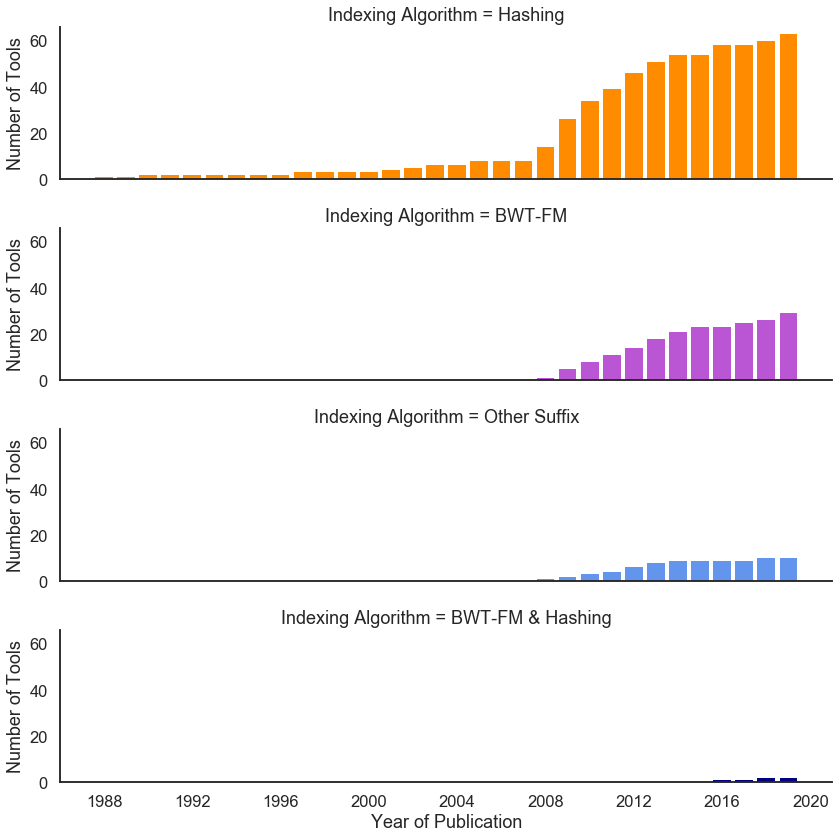

In [59]:
# plt.figure(figsize=(8,4))
sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_a_5.png')
plt.savefig('../figures/Figure2_a_5.pdf')

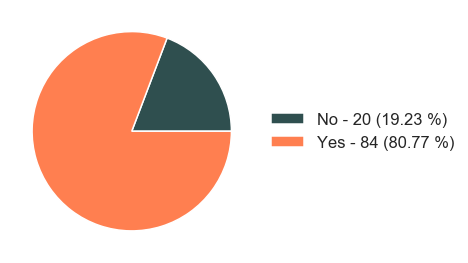

In [9]:
plt.figure(figsize=(12,4))

FLS_group = data_year.groupby('seeds_fixed').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(FLS_group.aligner, colors=['darkslategray', 'coral'])
pct = 100.*FLS_group.aligner/FLS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(FLS_group.index, FLS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_b_0.png')
plt.savefig('../figures/Figure2_b_0.pdf')

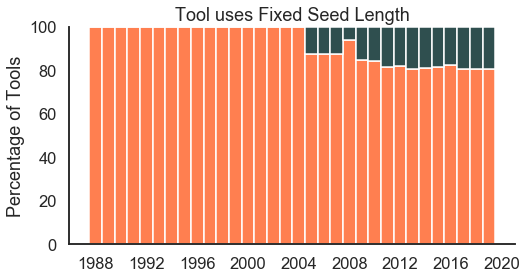

In [10]:
plt.figure(figsize=(8,4))
idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','seeds_fixed']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
x = by_year.index

totals = [i+j for i,j in zip(by_year['Yes'], by_year['No'])]
Y = [i / j * 100 for i,j in zip(by_year['Yes'], totals)]
N = [i / j * 100 for i,j in zip(by_year['No'], totals)]

sns.set_style('white')
sns.set_context('talk')

plt.bar(x, Y, color='coral', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='darkslategray', edgecolor='white', width=barWidth)

# plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
#               labels=['Yes', 'No'], colors=['coral', 'darkslategray'])
sns.despine()
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.ylabel("Percentage of Tools")
plt.title('Tool uses Fixed Seed Length')
#plt.tight_layout()

#plt.show()
plt.savefig('../figures/Figure2_b_1.png')
plt.savefig('../figures/Figure2_b_1.pdf')

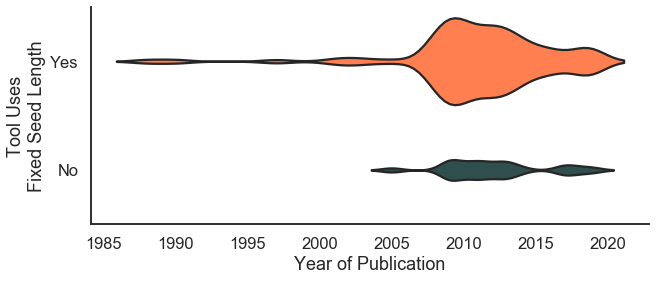

In [11]:
plt.figure(figsize=(10, 4))
sns.set_style('white')
sns.set_context('talk')

g = sns.violinplot(data=data_year, x='year_of_pub', y='seeds_fixed', scale='count', bw=.2, inner=None,
                   order=['Yes', 'No'], palette=['coral', 'darkslategray'], saturation=1)

plt.ylabel("Tool Uses\nFixed Seed Length")
plt.xlabel("Year of Publication")

sns.despine()

#plt.show()

plt.savefig('../figures/Figure2_b_4.png')
plt.savefig('../figures/Figure2_b_4.pdf')

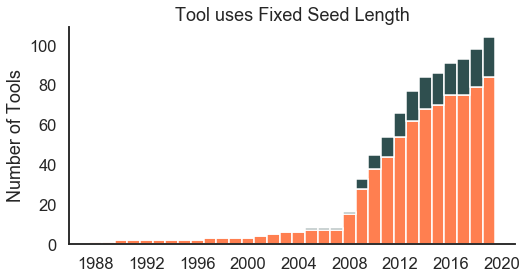

In [12]:
plt.figure(figsize=(8,4))
sns.set_style('white')
sns.set_context('talk')

Y = by_year['Yes'].to_list()
N = by_year['No'].to_list()

barWidth = 1
plt.bar(x, Y, color='coral', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='darkslategray', edgecolor='white', width=barWidth)
sns.despine()

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.title('Tool uses Fixed Seed Length')
plt.ylabel("Number of Tools")
#plt.tight_layout()

#plt.show()
plt.savefig('../figures/Figure2_b_2.png')
plt.savefig('../figures/Figure2_b_2.pdf')

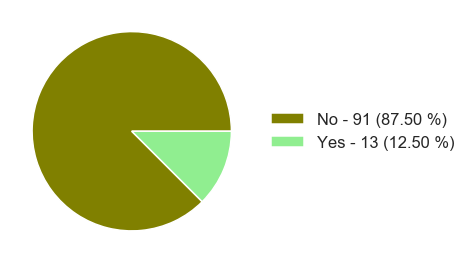

In [13]:
plt.figure(figsize=(12,4))

SS_group = data_year.groupby('seeds_spaced').count().sort_values('aligner', ascending=False)
patches, texts = plt.pie(SS_group.aligner, colors=['olive','lightgreen'])
pct = 100.*SS_group.aligner/SS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(SS_group.index, SS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_c_0.png')
plt.savefig('../figures/Figure2_c_0.pdf')

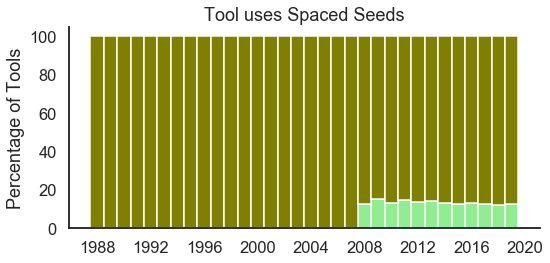

In [14]:
plt.figure(figsize=(8,4))
idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','seeds_spaced']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
x = by_year.index

#plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
#              labels=['Yes', 'No'], colors=['lightgreen','olive'])

totals = [i+j for i,j in zip(by_year['Yes'], by_year['No'])]
Y = [i / j * 100 for i,j in zip(by_year['Yes'], totals)]
N = [i / j * 100 for i,j in zip(by_year['No'], totals)]

sns.set_style('white')
sns.set_context('talk')

plt.bar(x, Y, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='olive', edgecolor='white', width=barWidth)


plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.title('Tool uses Spaced Seeds')
plt.ylabel("Percentage of Tools")
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_c_1.png')
plt.savefig('../figures/Figure2_c_1.pdf')

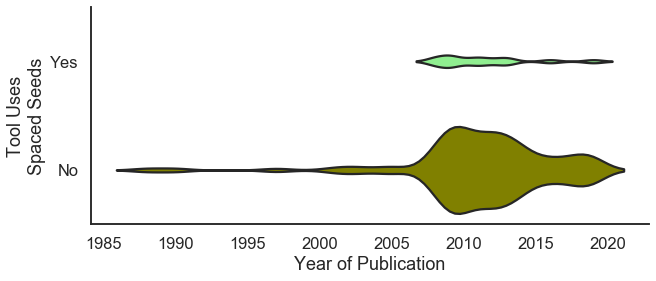

In [15]:
plt.figure(figsize=(10, 4))
sns.set_style('white')
sns.set_context('talk')

g = sns.violinplot(data=data_year, x='year_of_pub', y='seeds_spaced', scale='count', bw=.2, inner=None,
                   order=['Yes', 'No'], palette=['lightgreen', 'olive'], saturation=1)

plt.ylabel("Tool Uses\nSpaced Seeds")
plt.xlabel("Year of Publication")

sns.despine()

#plt.show()

plt.savefig('../figures/Figure2_c_4.png')
plt.savefig('../figures/Figure2_c_4.pdf')

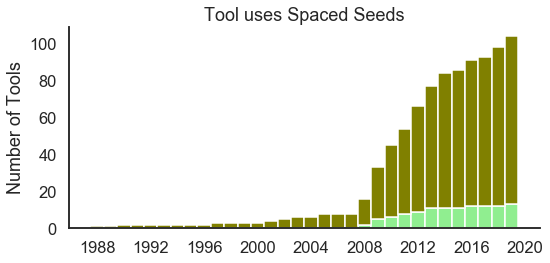

In [16]:
plt.figure(figsize=(8,4))
sns.set_style('white')
sns.set_context('talk')

Y = by_year['Yes'].to_list()
N = by_year['No'].to_list()

barWidth = 1
plt.bar(x, Y, color='lightgreen', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='olive', edgecolor='white', width=barWidth)
sns.despine()

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.title('Tool uses Spaced Seeds')
plt.ylabel('Number of Tools')
plt.tight_layout()

#plt.show()
plt.savefig('../figures/Figure2_c_2.png')
plt.savefig('../figures/Figure2_c_2.pdf')

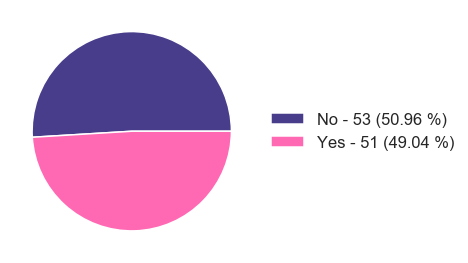

In [17]:
plt.figure(figsize=(12,4))

CS_group = data_year.groupby('seeds_chained').count().sort_values('aligner', ascending=False)
patches, texts = plt.pie(CS_group.aligner, colors=['darkslateblue','hotpink'])
pct = 100.*CS_group.aligner/CS_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(CS_group.index, CS_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_d_0.png')
plt.savefig('../figures/Figure2_d_0.pdf')

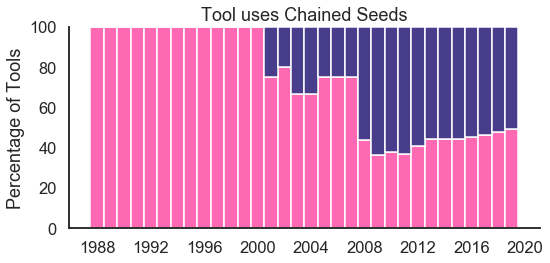

In [18]:
plt.figure(figsize=(8,4))
idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','seeds_chained']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
x = by_year.index

totals = [i+j for i,j in zip(by_year['Yes'], by_year['No'])]
Y = [i / j * 100 for i,j in zip(by_year['Yes'], totals)]
N = [i / j * 100 for i,j in zip(by_year['No'], totals)]

sns.set_style('white')
sns.set_context('talk')

plt.bar(x, Y, color='hotpink', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='darkslateblue', edgecolor='white', width=barWidth)

#plt.stackplot(x, by_year.loc[:,'Yes'], by_year.loc[:,'No'],
#              labels=['Yes', 'No'], colors=['hotpink','darkslateblue'])

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.title('Tool uses Chained Seeds')
plt.ylabel('Percentage of Tools')
plt.tight_layout()
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_d_1.png')
plt.savefig('../figures/Figure2_d_1.pdf')

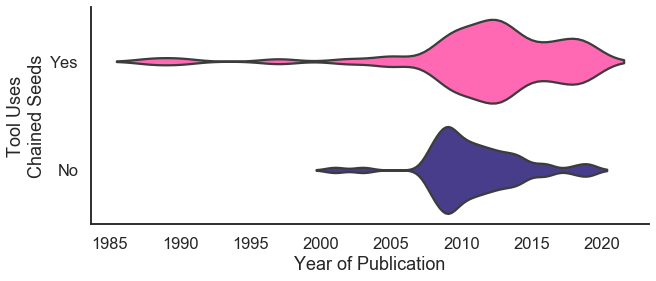

In [19]:
plt.figure(figsize=(10, 4))
sns.set_style('white')
sns.set_context('talk')

g = sns.violinplot(data=data_year, x='year_of_pub', y='seeds_chained', scale='count', bw=.2, inner=None,
                   order=['Yes', 'No'], palette=['hotpink', 'darkslateblue'], saturation=1)

plt.ylabel("Tool Uses\nChained Seeds")
plt.xlabel("Year of Publication")

sns.despine()

#plt.show()

plt.savefig('../figures/Figure2_d_4.png')
plt.savefig('../figures/Figure2_d_4.pdf')

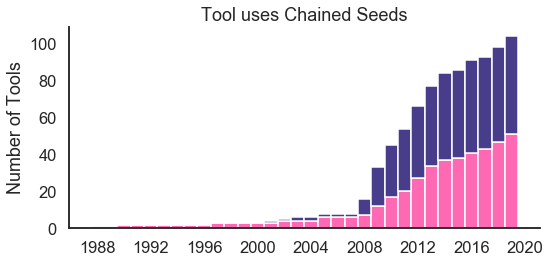

In [20]:
plt.figure(figsize=(8,4))
sns.set_style('white')
sns.set_context('talk')

Y = by_year['Yes'].to_list()
N = by_year['No'].to_list()

barWidth = 1
plt.bar(x, Y, color='hotpink', edgecolor='white', width=barWidth)
plt.bar(x, N, bottom=Y, color='darkslateblue', edgecolor='white', width=barWidth)
sns.despine()

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.title('Tool uses Chained Seeds')
plt.ylabel('Number of Tools')

plt.tight_layout()

#plt.show()
plt.savefig('../figures/Figure2_d_2.png')
plt.savefig('../figures/Figure2_d_2.pdf')

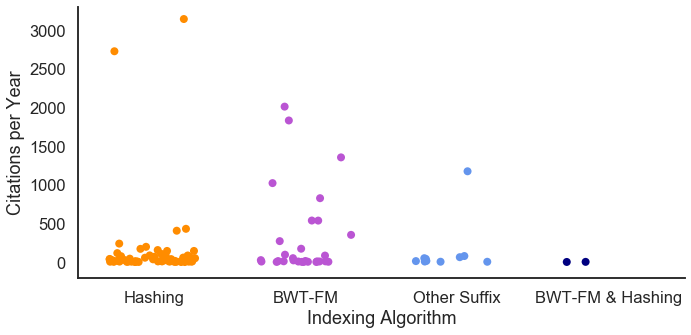

In [21]:
plt.figure(figsize=(10,5))

sns.set_style('white')
sns.set_context('talk')

ax = sns.stripplot(data = data, x = 'index', y = 'citation_per_year', 
                   order=['Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'], palette=index_clrs, 
                   size=8, jitter=.3)


ax.set(xlabel = 'Indexing Algorithm', ylabel = "Citations per Year")
plt.tight_layout()
sns.despine()

plt.savefig('../figures/Figure2_f_0.png')
plt.savefig('../figures/Figure2_f_0.pdf')

In [54]:
mwu = scp.stats.mannwhitneyu(data.loc[data['index'] == 'Hashing'].loc[:, 'citation_per_year'], 
                       data.loc[data['index'] == 'BWT-FM'].loc[:, 'citation_per_year'])

print(mwu)

MannwhitneyuResult(statistic=814.0, pvalue=0.20270441255479993)


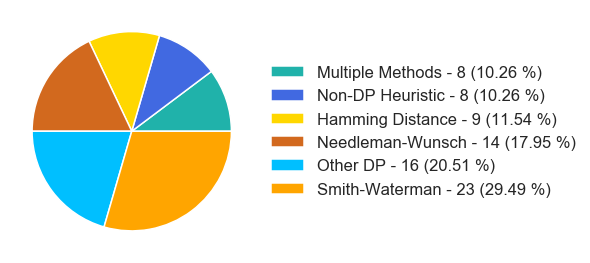

In [61]:
plt.figure(figsize=(12,4))

sns.set_style('white')
sns.set_context('talk')
pairwise_group = data_year.loc[data_year['application'].str.contains('DNA'), :].groupby('pairwise').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(pairwise_group.aligner, colors=local_clrs[::-1])
pct = 100.*pairwise_group.aligner/pairwise_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(pairwise_group.index, pairwise_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
#plt.show()
sns.despine()

plt.savefig('../figures/Figure2_e_0.png')
plt.savefig('../figures/Figure2_e_0.pdf')

In [62]:
idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','pairwise']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Pairwise Alignment Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})
year_melt


,Year of Publication,Pairwise Alignment Algorithm,Number of Tools
0,1988,Hamming Distance,0
1,1989,Hamming Distance,0
2,1990,Hamming Distance,0
3,1991,Hamming Distance,0
4,1992,Hamming Distance,0
5,1993,Hamming Distance,0
6,1994,Hamming Distance,0
7,1995,Hamming Distance,0
8,1996,Hamming Distance,0
9,1997,Hamming Distance,0


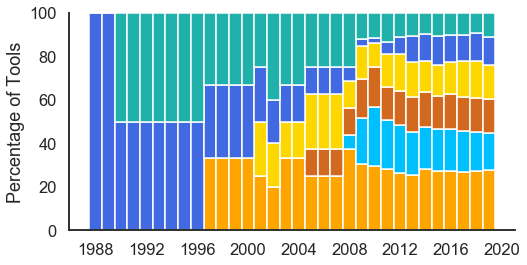

In [63]:
plt.figure(figsize=(8,4))


totals = [i+j+k+l+m+n for i,j,k,l,m,n in zip(by_year['Smith-Waterman'], by_year['Hamming Distance'], 
                                             by_year['Other DP'], by_year['Needleman-Wunsch'], 
                                             by_year['Multiple Methods'], by_year['Non-DP Heuristic'])]
SW = [i / j * 100 for i,j in zip(by_year['Smith-Waterman'], totals)]
HD = [i / j * 100 for i,j in zip(by_year['Hamming Distance'], totals)]
Other = [i / j * 100 for i,j in zip(by_year['Other DP'], totals)]
NW = [i / j * 100 for i,j in zip(by_year['Needleman-Wunsch'], totals)]
MM = [i / j * 100 for i,j in zip(by_year['Multiple Methods'], totals)]
NoDP = [i / j * 100 for i,j in zip(by_year['Non-DP Heuristic'], totals)]

sns.set_style('white')
sns.set_context('talk')

# plot
barWidth = 1
plt.bar(x, SW, color='orange', edgecolor='white', width=barWidth)
plt.bar(x, HD, bottom=SW, color='deepskyblue', edgecolor='white', width=barWidth)
plt.bar(x, Other, bottom=[i+j for i,j in zip(SW, HD)], color='chocolate', 
        edgecolor='white', width=barWidth)
plt.bar(x, NW, bottom=[i+j+k for i,j,k in zip(SW, HD, Other)], color='gold', 
        edgecolor='white', width=barWidth)
plt.bar(x, MM, bottom=[i+j+k+l for i,j,k,l in zip(SW, HD, Other, NW)], color='royalblue', 
        edgecolor='white', width=barWidth)
plt.bar(x, NoDP, bottom=[i+j+k+l+m for i,j,k,l,m in zip(SW, HD, Other, NW, MM)], color='lightseagreen', 
        edgecolor='white', width=barWidth)


#plt.legend(loc='center left', bbox_to_anchor=(1, .5))

sns.despine()
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.ylabel("Percentage of Tools")
# plt.tight_layout()
# plt.show()


plt.savefig('../figures/Figure2_e_1.png')
plt.savefig('../figures/Figure2_e_1.pdf')

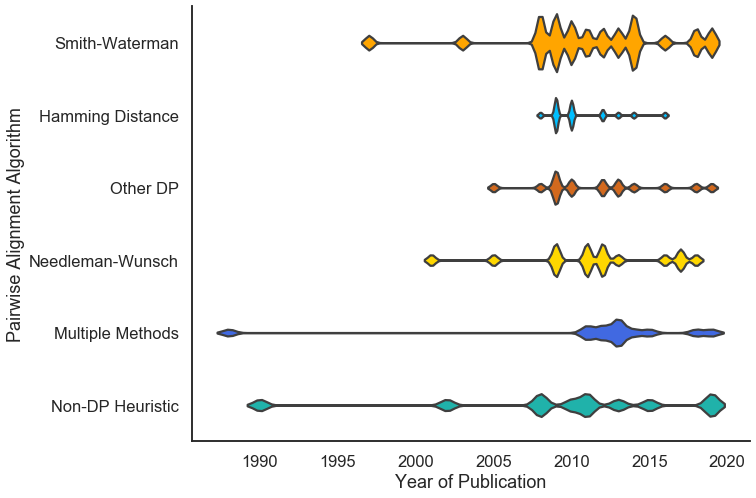

In [64]:
plt.figure(figsize=(10, 8))
sns.set_style('white')
sns.set_context('talk')

g = sns.violinplot(data=data_year, x='year_of_pub', y='pairwise', scale='count', bw=.05, inner=None,
                   order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch',
                         'Multiple Methods', 'Non-DP Heuristic'], palette=local_clrs, saturation=1)

plt.ylabel("Pairwise Alignment Algorithm")
plt.xlabel("Year of Publication")

sns.despine()

#plt.show()

plt.savefig('../figures/Figure2_e_4.png')
plt.savefig('../figures/Figure2_e_4.pdf')

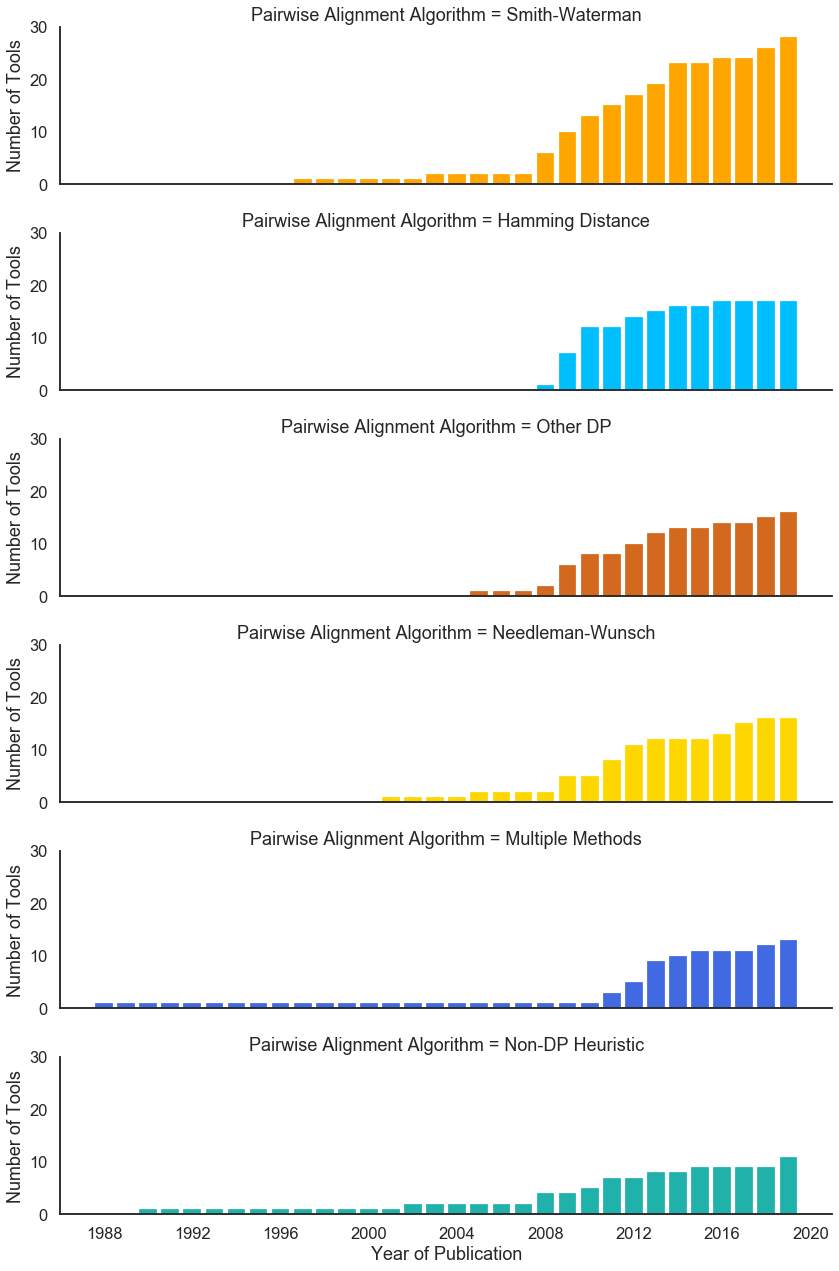

In [65]:
sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Pairwise Alignment Algorithm', aspect=4, hue='Pairwise Alignment Algorithm', 
                  row_order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch', 'Multiple Methods',
                            'Non-DP Heuristic'],
                  palette=local_clrs, hue_order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch',
                                                 'Multiple Methods', 'Non-DP Heuristic'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=.25)
plt.ylim(0, 30)
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
sns.despine()

#plt.show()
plt.savefig('../figures/Figure2_e_5.png')
plt.savefig('../figures/Figure2_e_5.pdf')

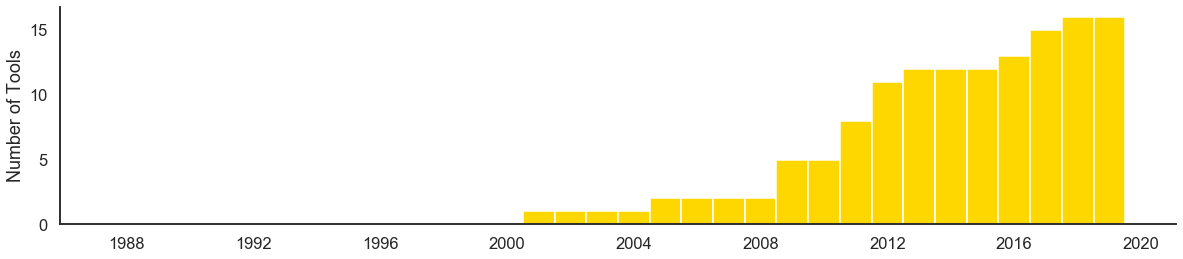

In [27]:
plt.figure(figsize=(20,4))

SW = by_year['Smith-Waterman'].to_list()
HD = by_year['Hamming Distance'].to_list()
Other = by_year['Other DP'].to_list()
NW = by_year['Needleman-Wunsch'].to_list()
MM = by_year['Multiple Methods'].to_list()
NoDP = by_year['Non-DP Heuristic'].to_list()

sns.set_style('white')
sns.set_context('talk')

# plot
barWidth = 1
plt.bar(x, NW, color='gold', 
        edgecolor='white', width=barWidth)

#plt.bar(x, SW, color='orange', edgecolor='white', width=barWidth)
#plt.bar(x, HD, bottom=SW, color='deepskyblue', edgecolor='white', width=barWidth)
#plt.bar(x, Other, bottom=[i+j for i,j in zip(SW, HD)], color='chocolate', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, NW, bottom=[i+j+k for i,j,k in zip(SW, HD, Other)], color='gold', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, MM, bottom=[i+j+k+l for i,j,k,l in zip(SW, HD, Other, NW)], color='royalblue', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, NoDP, bottom=[i+j+k+l+m for i,j,k,l,m in zip(SW, HD, Other, NW, MM)], color='lightseagreen', 
#        edgecolor='white', width=barWidth)
sns.despine()
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))

plt.ylabel("Number of Tools")
# plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_e_2.png')
plt.savefig('../figures/Figure2_e_2.pdf')

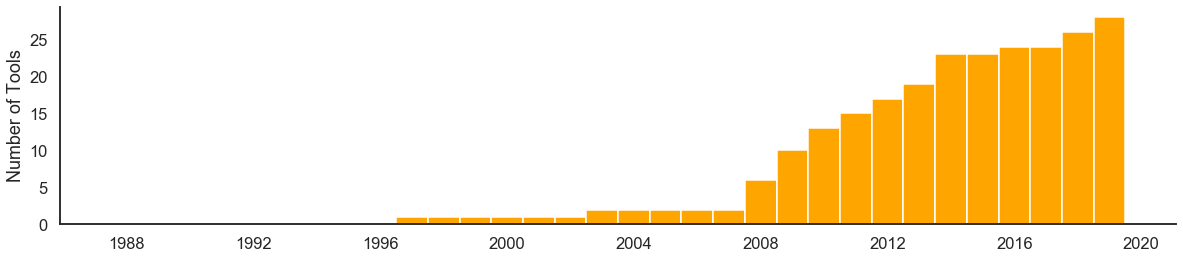

In [28]:
plt.figure(figsize=(20,4))

SW = by_year['Smith-Waterman'].to_list()
HD = by_year['Hamming Distance'].to_list()
Other = by_year['Other DP'].to_list()
NW = by_year['Needleman-Wunsch'].to_list()
MM = by_year['Multiple Methods'].to_list()
NoDP = by_year['Non-DP Heuristic'].to_list()

sns.set_style('white')
sns.set_context('talk')

# plot
barWidth = 1
plt.bar(x, SW, color='orange', 
        edgecolor='white', width=barWidth)

#plt.bar(x, SW, color='orange', edgecolor='white', width=barWidth)
#plt.bar(x, HD, bottom=SW, color='deepskyblue', edgecolor='white', width=barWidth)
#plt.bar(x, Other, bottom=[i+j for i,j in zip(SW, HD)], color='chocolate', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, NW, bottom=[i+j+k for i,j,k in zip(SW, HD, Other)], color='gold', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, MM, bottom=[i+j+k+l for i,j,k,l in zip(SW, HD, Other, NW)], color='royalblue', 
#        edgecolor='white', width=barWidth)
#plt.bar(x, NoDP, bottom=[i+j+k+l+m for i,j,k,l,m in zip(SW, HD, Other, NW, MM)], color='lightseagreen', 
#        edgecolor='white', width=barWidth)
sns.despine()
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
plt.ylabel("Number of Tools")
# plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure2_e_2.png')
plt.savefig('../figures/Figure2_e_2.pdf')

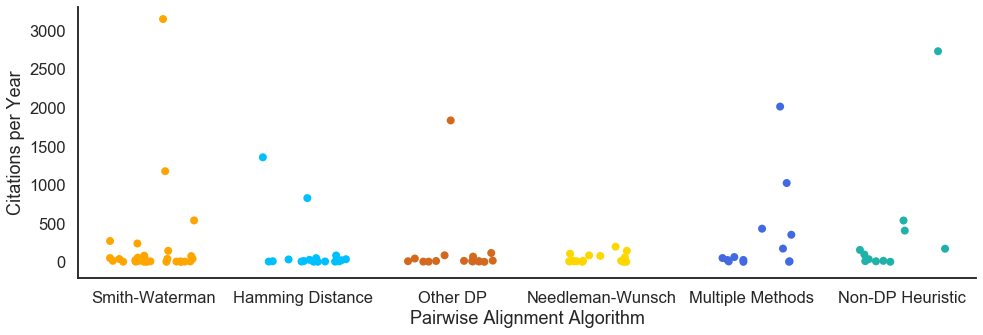

In [29]:
plt.figure(figsize=(14,5))

sns.set_style('white')
sns.set_context('talk')
#ax = sns.boxplot(data=data_cite, x='pairwise', y='citation_per_year',  
#                order=['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP', 'Non-DP Heuristic',
#                     'Multiple Methods'], color="1", fliersize=0, whis=0)

#max_sw = max(data_cite.loc[data_cite['pairwise'] == 'Smith-Waterman', 'citation_per_year'])
#sw_tool = data_cite.loc[data_cite['citation_per_year'] == max_sw].aligner.values[0]
#max_hd = max(data_cite.loc[data_cite['pairwise'] == 'Hamming Distance', 'citation_per_year'])
#hd_tool = data_cite.loc[data_cite['citation_per_year'] == max_hd].aligner.values[0]
#max_other = max(data_cite.loc[data_cite['pairwise'] == 'Other DP', 'citation_per_year'])
#other_tool = data_cite.loc[data_cite['citation_per_year'] == max_other].aligner.values[0]
#max_nw = max(data_cite.loc[data_cite['pairwise'] == 'Needleman-Wunsch', 'citation_per_year'])
#nw_tool = data_cite.loc[data_cite['citation_per_year'] == max_nw].aligner.values[0]
#max_nodp = max(data_cite.loc[data_cite['pairwise'] == 'Non-DP Heuristic', 'citation_per_year'])
#nodp_tool = data_cite.loc[data_cite['citation_per_year'] == max_nodp].aligner.values[0]
#max_mm = max(data_cite.loc[data_cite['pairwise'] == 'Multiple Methods', 'citation_per_year'])
#mm_tool = data_cite.loc[data_cite['citation_per_year'] == max_mm].aligner.values[0]

ax = sns.stripplot(data=data, x='pairwise', y='citation_per_year',  
                order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch',
                     'Multiple Methods', 'Non-DP Heuristic'], palette=local_clrs, size=8, jitter=.3)

#plt.annotate(sw_tool, xy=(0, max_sw), 
#             xytext=(0, max_sw+500), xycoords='data', horizontalalignment="center")
#plt.annotate(hd_tool, xy=(0, max_hd), 
#             xytext=(1, max_hd+500), xycoords='data', horizontalalignment="center")
#plt.annotate(other_tool, xy=(0, max_other), 
#             xytext=(2, max_other+500), xycoords='data', horizontalalignment="center")
#plt.annotate(nw_tool, xy=(0, max_nw), 
#             xytext=(3, max_nw+500), xycoords='data', horizontalalignment="center")
#plt.annotate(mm_tool, xy=(0, max_mm), 
#             xytext=(4, max_mm+500), xycoords='data', horizontalalignment="center")
#plt.annotate(nodp_tool, xy=(0, max_nodp), 
#             xytext=(5, max_nodp+500), xycoords='data', horizontalalignment="center")


ax.set(xlabel = 'Pairwise Alignment Algorithm', ylabel = "Citations per Year")
plt.tight_layout()
sns.despine()
#ax.set_xticklabels(rotation=40, ha="right")
#plt.show()
plt.savefig('../figures/Figure2_g_0.png')
plt.savefig('../figures/Figure2_g_0.pdf')

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

agg = pd.read_csv('../raw_data/aggregate_tool_info.csv')
agg = agg.rename(columns={"indexing":"source","seed_type":"type","pairwise_alignment":"target","count":"value"})
agg = agg.dropna()
agg

,source,type,target,value
0,BWT-FM,NNN,HD,1
1,BWT-FM,NNN,SW,1
2,BWT-FM,NNN,Semi-Global,1
3,BWT-FM,NNY,NW,2
4,BWT-FM,NNY,SW,2
5,BWT-FM,NNY,SW & NW,2
6,BWT-FM,YNN,Banded Myers Bit Vector,1
7,BWT-FM,YNN,HD,4
8,BWT-FM,YNN,Non-DP Heuristic,4
9,BWT-FM,YNN,SW,4


In [31]:
from ipysankeywidget import SankeyWidget
from floweaver import *

size = dict(width=1200, height=600)

nodes = {
    'index': ProcessGroup(['hashing', 'BWT-FM', 'BWT-FM + hashing', 'BWT-ST', 'suffix array', 'suffix tree']),
    'pairwise': ProcessGroup(['Banded Myers Bit Vector', 'HD', 'NW', 'SW',
                             'SW & NW', 'SW & Semi-Global', 'Non-DP Heuristic',
                             'Landau-Vishkin', 'Rabin-Karp Algorithm',
                             'Sparse DP', 'Semi-Global', 'Myers Bit-Vector']),
}

#nodes = {
#    'index': ProcessGroup(['Hashing', 'BWT-FM', 'BWT-ST', 'Suffix Array', 'Suffix Tree']),
#    'pairwise': ProcessGroup(['Banded Myers Bit Vector', 'Based on the Wrapper, Local and Global', 'Global', 'Local',
#                             'Hamming Distance', 'Local & Global', 'Local & Semi-Global', 'Non-DP Heuristic',
#                             'Hamming, Local, and Global Alignment', 'Landau-Vishkin', 'Rabin-Karp Algorithm',
#                             'Sparse DP', 'Semi-Global']),
#}

ordering = [
    ['index'],  
    ['pairwise'],
]

bundles = [
    Bundle('index', 'pairwise'),
]

sdd = SankeyDefinition(nodes, bundles, ordering)
weave(sdd, agg).to_widget(**size, margins=dict(top=0, bottom=0, left=50, right=100))

SankeyWidget(layout=Layout(height='600', width='1200'), links=[{'source': 'index^*', 'target': 'pairwise^*', '…

In [32]:
index_part = Partition.Simple('process', [
    'BWT-FM',
    ('BWT-FM & Hashing', ['BWT-FM + hashing']),
    ('Hashing', ['hashing']),
    ('Other Suffix', ['BWT-ST', 'suffix array', 'suffix tree']),
])

pairwise_part = Partition.Simple('process', [
    ('Smith-Waterman', ['SW']),
    ('Hamming Distance', ['HD']),
    ('Needleman-Wunsch', ['NW']),
    ('Other DP', ['Rabin-Karp Algorithm', 'Landau-Vishkin', 'Sparse DP', 'Banded Myers Bit Vector', 
                  'Semi-Global', 'Myers Bit-Vector']),
    'Non-DP Heuristic',
    ('Multiple Methods', ['SW & NW', 'SW & Semi-Global',])
])

#pairwise_part = Partition.Simple('process', [
#    'Local',
#    'Hamming Distance',
#    'Global',
#    'Non-DP Heuristic',
#    ('Multiple Methods', ['Based on the Wrapper, Local and Global', 'Local & Global', 'Local & Semi-Global', 
#                          'Hamming, Local, and Global Alignment']),
#    ('Other DP', ['Rabin-Karp Algorithm', 'Landau-Vishkin', 'Sparse DP', 
#                          'Banded Myers Bit Vector', 'Semi-Global'])
#])

nodes['index'].partition = index_part
nodes['pairwise'].partition = pairwise_part
weave(sdd, agg).to_widget(**size, margins=dict(top=0, bottom=0, left=140, right=160))

SankeyWidget(groups=[{'id': 'index', 'type': 'process', 'title': '', 'nodes': ['index^BWT-FM', 'index^BWT-FM &…

In [33]:
part_by_index = Partition.Simple('source', [
    'BWT-FM', 
    ('BWT-FM & Hashing', ['BWT-FM + hashing']),
    ('Hashing', ['hashing']),
    ('Other Suffix', ['BWT-ST', 'suffix array', 'suffix tree']),
])
pal = ['mediumorchid', 'navy', 'darkorange', 'cornflowerblue' ]
sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=part_by_index)
weave(sdd, agg, palette=pal).to_widget(**size, margins=dict(top=0, bottom=0, left=140, right=160)).auto_save_png(
    '../figures/Figure2_h_0.png')

SankeyWidget(groups=[{'id': 'index', 'type': 'process', 'title': '', 'nodes': ['index^BWT-FM', 'index^BWT-FM &…

In [40]:
data.loc[:,['aligner', 'indexing', 'pairwise', 'citation_per_year']].sort_values(by='citation_per_year', 
                                                                                 ascending=False)

,aligner,indexing,pairwise,citation_per_year
79,Gapped BLAST,hashing,Smith-Waterman,3143.304348
80,BLAST,hashing,Non-DP Heuristic,2726.400000
31,Bowtie2,BWT-FM,Multiple Methods,2010.125000
53,BWA,BWT-FM,Other DP,1831.181818
52,Bowtie,BWT-FM,Hamming Distance,1353.636364
92,STAR,suffix array,Smith-Waterman,1173.857143
93,TopHat2,BWT-FM,Multiple Methods,1020.857143
102,TopHat,BWT-FM,Hamming Distance,825.818182
44,BWA-SW,BWT-FM,Smith-Waterman,536.800000
89,HISAT,BWT-FM,Non-DP Heuristic,536.000000


In [41]:
data.loc[:,['aligner', 'indexing', 'pairwise', 'year_of_pub']].sort_values(by='year_of_pub')

,aligner,indexing,pairwise,year_of_pub
85,FASTA,hashing,Multiple Methods,1988
80,BLAST,hashing,Non-DP Heuristic,1990
79,Gapped BLAST,hashing,Smith-Waterman,1997
76,SSAHA,hashing,Needleman-Wunsch,2001
75,Blat,hashing,Non-DP Heuristic,2002
74,BLASTZ,hashing,Smith-Waterman,2003
73,GMAP,hashing,Needleman-Wunsch,2005
72,C4,hashing,Other DP,2005
103,QPALMA,suffix array,Smith-Waterman,2008
65,BWT-SW,BWT-FM,Smith-Waterman,2008
